In [ ]:
#importing required libraries and packages

import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

In [ ]:
#printing out versions of all packages and libraries and used

print(f'pandas version is: {pd.__version__}')
print(f'numpy version is: {np.__version__}')
print(f'matplotlib version is: {matplotlib.__version__}')
print(f'sklearn version is: {sklearn.__version__}')
print(f'xgboost version is: {xgb.__version__}')

pandas version is: 2.1.4
numpy version is: 1.26.4
matplotlib version is: 3.8.0
sklearn version is: 1.2.2
xgboost version is: 2.1.3


In [ ]:
import xgboost
from xgboost import XGBClassifier

print("Version:", xgboost.__version__)
print("XGBClassifier from:", XGBClassifier.__module__)
print("xgboost module path:", xgboost.__file__)

Version: 2.1.3
XGBClassifier from: xgboost.sklearn
xgboost module path: C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\__init__.py


In [ ]:
#all helper functions used

def drop_columns(data, *args):

    '''
    function used to drop columns.
    args::
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''

    columns = []
    for _ in args:
        columns.append(_)

    data = data.drop(columns, axis=1)

    return data

def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args::
      data:  dataframe to be operated on

    returns dataframe with replaced values
    '''

    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])

    return data

def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#should be edited to the present working directory of the user
#PWD = '/content/drive/My Drive/FORCE-Lithology-Prediction/'

In [ ]:
# Define base directory relative to your known home
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

In [ ]:
#importing penaltry matrix used for evaluation and train and test files
A = np.load(base_dir / 'penalty_matrix.npy')

train = pd.read_csv(base_dir / 'train.csv', sep=';')

test = pd.read_csv(base_dir / 'hidden_test.csv', sep=';')

In [ ]:
class Model():

    '''
    class to lithology prediction
    '''

    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''

        self.train = train
        self.test = test


    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}

        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values

        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''



        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)

        df = df.fillna(-999)
        df = process(df)
        data = df.copy()

        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')

        #traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        #testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        traindata1 = pd.DataFrame(traindata).values
        testdata1 = pd.DataFrame(testdata).values

        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')



        return traindata1, testdata1, lithology1, lithology_numbers


    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)

      open_test = np.zeros((len(testdata1), 12))

      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9,
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500, early_stopping_rounds=100)


      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]

        model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

        print(f'-----------------------FOLD {i}---------------------')
        i+=1

        open_test += model.predict_proba(pd.DataFrame(testdata1))

      open_test= pd.DataFrame(open_test/split)

      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))

      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')


      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers


    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)

      #path = PWD

      test = pd.read_csv(base_dir /'hidden_test.csv', sep=';')

      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

shape of concatenated dataframe before dropping columns (1292908, 29)
shape of dataframe after dropping columns (1292908, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1292908, 27)
Splitting concatenated dataframe into training and test datasets...
(1292908, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (122397, 23))
Shape of train and test datasets after augmentation ((1170511, 23), (122397, 23))


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:26:36] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16669
[99]	validation_0-mlogloss:0.32722
Default score: [-0.27937797]
Accuracy is: 0.8944315347025253
F1 is: 0.8984344504665472
None
-----------------------FOLD 1---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:27:21] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16712
[99]	validation_0-mlogloss:0.32984
Default score: [-0.28157918]
Accuracy is: 0.8931576834029611
F1 is: 0.8973230560110259
None
-----------------------FOLD 2---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:17] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16774
[99]	validation_0-mlogloss:0.33144
Default score: [-0.2838549]
Accuracy is: 0.8926365430453392
F1 is: 0.8966807328704008
None
-----------------------FOLD 3---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:29:12] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16695
[99]	validation_0-mlogloss:0.33005
Default score: [-0.28332415]
Accuracy is: 0.8926365430453392
F1 is: 0.8968800540891716
None
-----------------------FOLD 4---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:05] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16720
[99]	validation_0-mlogloss:0.33163
Default score: [-0.2834822]
Accuracy is: 0.8923460713705992
F1 is: 0.89649542358001
None
-----------------------FOLD 5---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:31:02] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16701
[99]	validation_0-mlogloss:0.32939
Default score: [-0.28058816]
Accuracy is: 0.8936873670451342
F1 is: 0.8976836900098942
None
-----------------------FOLD 6---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:31:58] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16732
[99]	validation_0-mlogloss:0.33098
Default score: [-0.28357938]
Accuracy is: 0.892431504216111
F1 is: 0.8964957100999901
None
-----------------------FOLD 7---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:57] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16755
[99]	validation_0-mlogloss:0.33038
Default score: [-0.28050059]
Accuracy is: 0.8938411461670553
F1 is: 0.8980357541065573
None
-----------------------FOLD 8---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:53] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16755
[99]	validation_0-mlogloss:0.33390
Default score: [-0.28536813]
Accuracy is: 0.8919957967040009
F1 is: 0.8962117345083517
None
-----------------------FOLD 9---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:50] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16771
[99]	validation_0-mlogloss:0.33192
Default score: [-0.28176393]
Accuracy is: 0.8930893371265517
F1 is: 0.8972281859309086
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


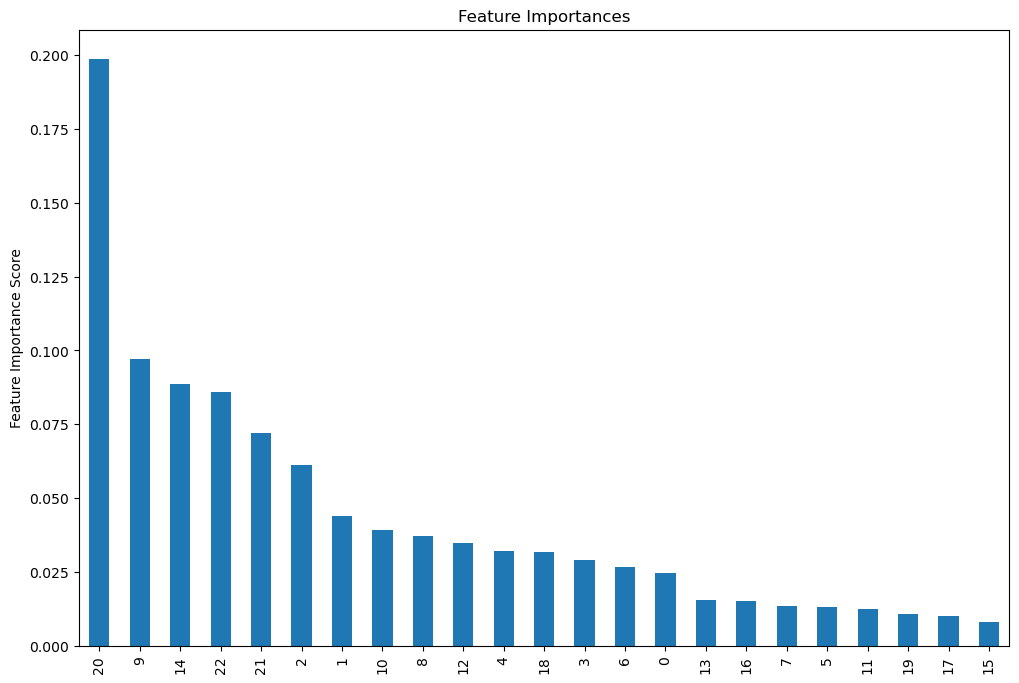

In [ ]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [ ]:
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [ ]:
len(prediction)

122397

In [ ]:
from pathlib import Path
import numpy as np

lithology_numbers = {30000: 0,
                65030: 1,
                65000: 2,
                80000: 3,
                74000: 4,
                70000: 5,
                70032: 6,
                88000: 7,
                86000: 8,
                99000: 9,
                90000: 10,
                93000: 11}
# Set base directory (adjust if needed)
base_dir_N = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

# Map predicted class numbers back to original lithology codes
category_to_lithology = {y: x for x, y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)

# Define full path to save file
filename = "Olawale_Predictions_BaseXGB"
output_file = base_dir_N / f"{filename}.csv"

# Save the prediction file
np.savetxt(output_file, test_prediction_for_submission, header='lithology', fmt='%i', comments='')

In [ ]:
len(test_prediction_for_submission)

122397

In [ ]:
type(test_prediction_for_submission)

numpy.ndarray

# Just Run Separate: Comparing with actual test predictions

In [ ]:
# Define base directory relative to your known home
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

test = pd.read_csv(base_dir / 'hidden_test.csv', sep=';')

In [ ]:
test.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [ ]:
actual_class = test['FORCE_2020_LITHOFACIES_LITHOLOGY'].to_numpy()

In [ ]:
# Define base directory relative to your known home
base_dir_predict = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

In [ ]:
pred_df = pd.read_csv(base_dir_predict / 'Olawale_Predictions_BaseXGB.csv', sep=';')
pred_df

,lithology
0,65000
1,65000
2,65000
3,65000
4,65000
...,...
122392,65000
122393,65000
122394,65000
122395,65000


In [ ]:
test_prediction_for_submission = pred_df['lithology'].to_numpy()

In [ ]:
test_prediction_for_submission

array([65000, 65000, 65000, ..., 65000, 65000, 65000], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(actual_class, test_prediction_for_submission)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.7960


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_class, test_prediction_for_submission, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.7717


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(test_prediction_for_submission, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value 30000: 14363 times
Value 65000: 79878 times
Value 65030: 6097 times
Value 70000: 9986 times
Value 70032: 60 times
Value 74000: 6 times
Value 80000: 3713 times
Value 86000: 551 times
Value 88000: 6516 times
Value 90000: 147 times
Value 99000: 1080 times


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(actual_class, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value 30000: 14045 times
Value 65000: 71827 times
Value 65030: 12283 times
Value 70000: 8374 times
Value 70032: 2905 times
Value 74000: 287 times
Value 80000: 4396 times
Value 86000: 597 times
Value 88000: 6498 times
Value 90000: 244 times
Value 99000: 941 times


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Original label mapping (in desired order)
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coals',
    93000: 'Basement'
}

# Convert actual and predicted to string labels using the mapping
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value Anhydrite: 551 times
Value Chalk: 60 times
Value Coals: 147 times
Value Dolomite: 6 times
Value Halite: 6516 times
Value Limestone: 9986 times
Value Marl: 3713 times
Value Sandstone: 14363 times
Value Sandstone/Shale: 6097 times
Value Shale: 79878 times
Value Tuff: 1080 times


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(actual_labels, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value Anhydrite: 597 times
Value Chalk: 2905 times
Value Coals: 244 times
Value Dolomite: 287 times
Value Halite: 6498 times
Value Limestone: 8374 times
Value Marl: 4396 times
Value Sandstone: 14045 times
Value Sandstone/Shale: 12283 times
Value Shale: 71827 times
Value Tuff: 941 times


In [ ]:
from sklearn.metrics import confusion_matrix

# Example arrays
actual = actual_class
predicted = test_prediction_for_submission

# Construct confusion matrix
cm = confusion_matrix(actual, predicted)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[11072  1336  1206   237     0     0   194     0     0     0     0]
 [  538 68520   949   228     0     0  1326    10     9    18   229]
 [ 1870  6733  3368    16     0     0   165     0     0     7   124]
 [  643  1192    96  5555    10     0   830    10     0     0    38]
 [  163     0     0  2689    50     0     3     0     0     0     0]
 [    2   162     0     9     0     0     3   109     2     0     0]
 [   14  1589   460  1141     0     0  1192     0     0     0     0]
 [   20     8     0    92     0     6     0   416    55     0     0]
 [    0    28     0    14     0     0     0     6  6450     0     0]
 [   40    64    18     0     0     0     0     0     0   122     0]
 [    1   246     0     5     0     0     0     0     0     0   689]]


In [ ]:
import numpy as np

unique, counts = np.unique(actual_class, return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 14045 samples
Lithology 65000: 71827 samples
Lithology 65030: 12283 samples
Lithology 70000: 8374 samples
Lithology 70032: 2905 samples
Lithology 74000: 287 samples
Lithology 80000: 4396 samples
Lithology 86000: 597 samples
Lithology 88000: 6498 samples
Lithology 90000: 244 samples
Lithology 99000: 941 samples


In [ ]:
import numpy as np

unique, counts = np.unique(test_prediction_for_submission, return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 14363 samples
Lithology 65000: 79878 samples
Lithology 65030: 6097 samples
Lithology 70000: 9986 samples
Lithology 70032: 60 samples
Lithology 74000: 6 samples
Lithology 80000: 3713 samples
Lithology 86000: 551 samples
Lithology 88000: 6516 samples
Lithology 90000: 147 samples
Lithology 99000: 1080 samples


In [ ]:

# Ensure actual and predicted labels are string-mapped
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)

# Keep label order
ordered_labels = list(lithology_keys.values())

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=ordered_labels)

# Convert to DataFrame for clean display
df_cm = pd.DataFrame(cm, index=ordered_labels, columns=ordered_labels)

# Display
print("Confusion Matrix (Raw Counts):")
df_cm

Confusion Matrix (Raw Counts):


,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Halite,Anhydrite,Tuff,Coals,Basement
Sandstone,11072,1206,1336,194,0,237,0,0,0,0,0,0
Sandstone/Shale,1870,3368,6733,165,0,16,0,0,0,124,7,0
Shale,538,949,68520,1326,0,228,0,9,10,229,18,0
Marl,14,460,1589,1192,0,1141,0,0,0,0,0,0
Dolomite,2,0,162,3,0,9,0,2,109,0,0,0
Limestone,643,96,1192,830,0,5555,10,0,10,38,0,0
Chalk,163,0,0,3,0,2689,50,0,0,0,0,0
Halite,0,0,28,0,0,14,0,6450,6,0,0,0
Anhydrite,20,0,8,0,6,92,0,55,416,0,0,0
Tuff,1,0,246,0,0,5,0,0,0,689,0,0


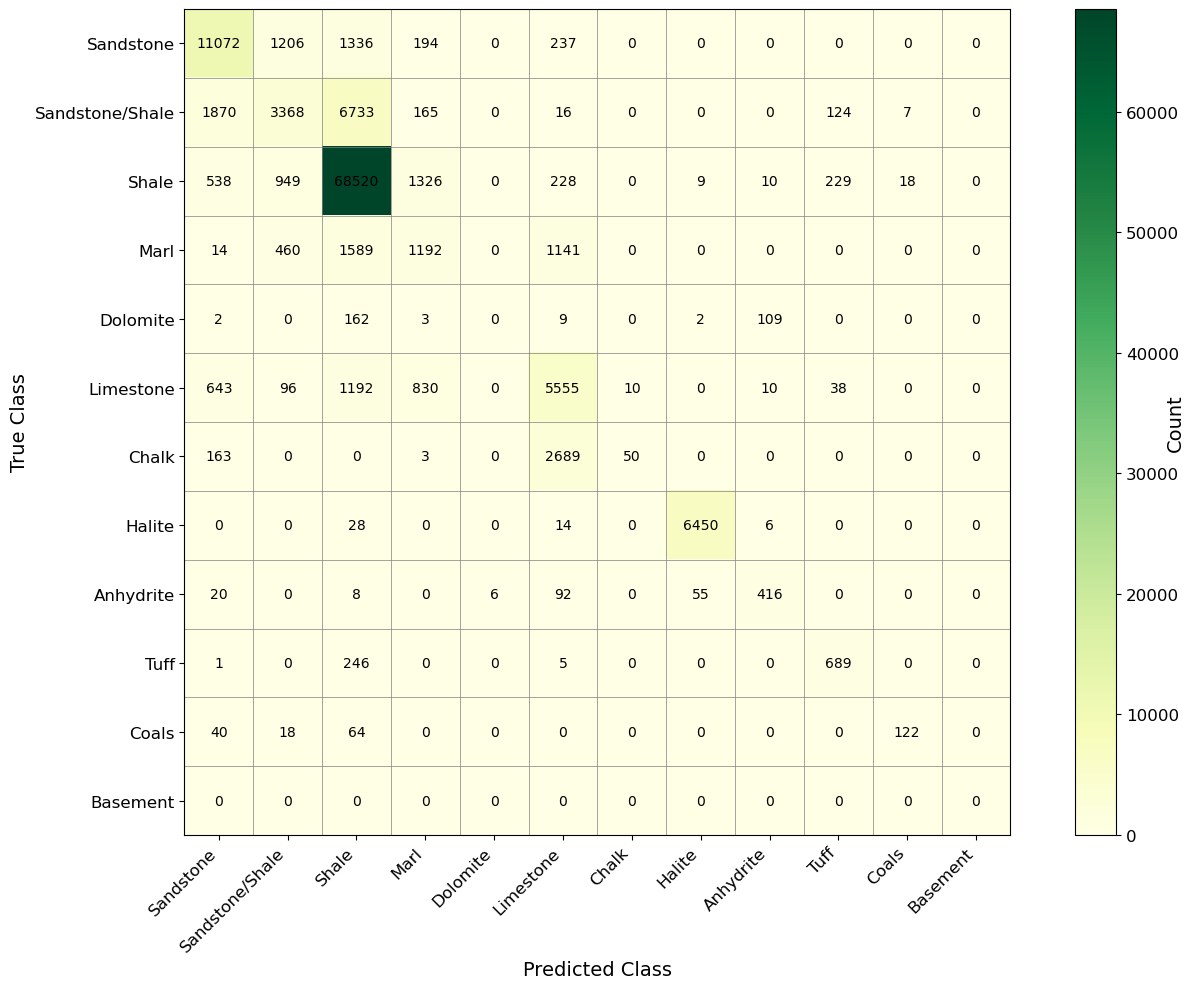

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
data = df_cm.values
row_labels = df_cm.index.tolist()
col_labels = df_cm.columns.tolist()

fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.YlGn  # Use the same colormap
im = ax.imshow(data, cmap=cmap)

# Add colorbar (gradient legend)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=90, va="bottom", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Show ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(row_labels, fontsize=12)

# Gridlines
ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate cells with counts
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, data[i, j], ha="center", va="center", color="black", fontsize=10)

# Titles and labels
#ax.set_title("Confusion Matrix of XGBoost without Data Augmentation", fontsize=16, pad=20)
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_xgboost_without_augmentation.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Map numeric predictions/actuals to strings
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)

# Ensure consistent label order
ordered_labels = list(lithology_keys.values())

# Generate report
report = classification_report(actual_labels, predicted_labels, labels=ordered_labels, zero_division=0)

# Print
print("Classification Report:\n")
print(report)


Classification Report:

                 precision    recall  f1-score   support

      Sandstone       0.77      0.79      0.78     14045
Sandstone/Shale       0.55      0.27      0.37     12283
          Shale       0.86      0.95      0.90     71827
           Marl       0.32      0.27      0.29      4396
       Dolomite       0.00      0.00      0.00       287
      Limestone       0.56      0.66      0.61      8374
          Chalk       0.83      0.02      0.03      2905
         Halite       0.99      0.99      0.99      6498
      Anhydrite       0.75      0.70      0.72       597
           Tuff       0.64      0.73      0.68       941
          Coals       0.83      0.50      0.62       244
       Basement       0.00      0.00      0.00         0

      micro avg       0.80      0.80      0.80    122397
      macro avg       0.59      0.49      0.50    122397
   weighted avg       0.78      0.80      0.77    122397



In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have your true and predicted values
accuracy = accuracy_score(actual_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7960


In [ ]:
def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

# Final Scoring FORCE METRIC

In [ ]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

In [ ]:
def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [ ]:
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [ ]:
actual

array([65000, 65000, 65000, ..., 65000, 65000, 65000], dtype=int64)

In [ ]:
lithology_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}
# Map using vectorized approach
y_true = np.vectorize(lithology_numbers.get)(actual)
y_true

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
custom_score = score(y_true, prediction)
custom_score

-0.49076774757551245